# Importing Libraries

In [38]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore", category=DeprecationWarning)


%matplotlib inline

# Reading Data from CSV files

In [39]:
test  = pd.read_csv('test_Y3wMUE5_7gLdaTN.csv')
train = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')

# Combining training and testing data for preprocessing

In [40]:
totalData = train.append(test, ignore_index=True)
train.head(10)

C:\Users\ketan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


# Preprocessing and Reducing the noise 

In [41]:
pd.options.mode.chained_assignment = None
totalData['Gender'].fillna(1, inplace=True)
totalData['Married'].fillna(1, inplace=True)
totalData['Credit_History'].fillna(totalData['Credit_History'].apply(float).median(), inplace=True)
totalData['Self_Employed'].fillna(1, inplace=True)

In [42]:
totalData.Dependents[totalData.Dependents =='3+' ] = 5
totalData['Dependents'].fillna(totalData['Dependents'].apply(float).median(), inplace=True)
totalData.Dependents[totalData.Dependents =='0'] = 0
totalData.Dependents[totalData.Dependents ==0.0] = 0
totalData.Dependents[totalData.Dependents =='1' ] = 1
totalData.Dependents[totalData.Dependents =='2' ] = 2

# Handling categorical features

In [43]:
column_names_for_onehot = ['Property_Area','Self_Employed','Education','Married','Gender','Dependents']
totalData = pd.get_dummies(totalData, columns=column_names_for_onehot, drop_first=True)

In [44]:
totalData.Loan_Status[totalData.Loan_Status =='Y' ] = 1
totalData.Loan_Status[totalData.Loan_Status =='N' ] = 0
totalData.Loan_Status.unique()
totalData.groupby(['Loan_Status']).size()

Loan_Status
0    192
1    422
dtype: int64

# Preparing training and testing data for applying models

In [45]:
totalData = totalData.drop(["Loan_ID"], axis=1)
trainingData = totalData.iloc[:(train.shape[0])]
testingData = totalData.iloc[(train.shape[0]):]

trainingData = trainingData.dropna(axis=0)
y_train = trainingData['Loan_Status']
x_train = trainingData.iloc[:(train.shape[0])].drop(["Loan_Status"], axis=1)
y_train = y_train.astype('int')

x_test = testingData.drop(["Loan_Status"], axis=1)
x_test = x_test.fillna(0)

# Data Visulization function for PCA and SVD

In [46]:
def dataVisulizationFunction(components, method, y_total):
    principleDf = pd.concat([pd.DataFrame(data = components, columns=['Comp1', 'Comp2']), y_total], axis=1)

    #Graph ploting
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Component 1', fontsize=15)
    ax.set_ylabel('Component 2', fontsize=15)
    ax.set_title("Data visulization using 2 components using - {}".format(method), fontsize=20)

    targets = [0, 1]
    colors = ['r', 'b']

    for target, color in zip(targets, colors):
        indicesToKeep = principleDf['Loan_Status'] == target
        ax.scatter(principleDf.loc[indicesToKeep, 'Comp1'], principleDf.loc[indicesToKeep, 'Comp2'], c = color, s = 50)

    ax.legend(targets)
    ax.grid()

# PCA implementation

Variance content of 2 components :[0.16837901 0.11846668]


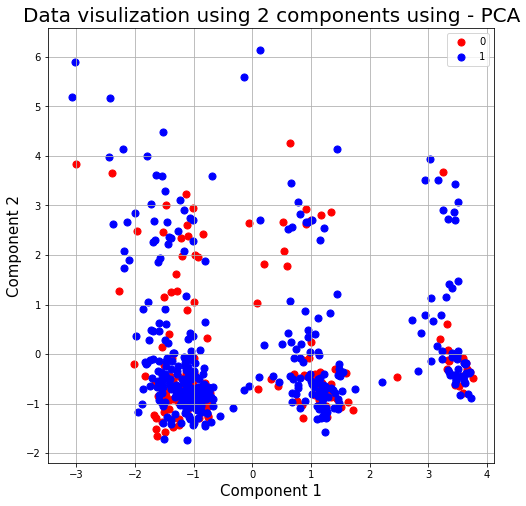

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

scalar = StandardScaler()
scalar.fit(x_train)
x = scalar.transform(x_train)
pca = PCA(n_components=2)
pcaComponents = pca.fit_transform(x)
dataVisulizationFunction(pcaComponents,"PCA", y_train)
print("Variance content of 2 components :{}".format(pca.explained_variance_ratio_))

# SVD implementation

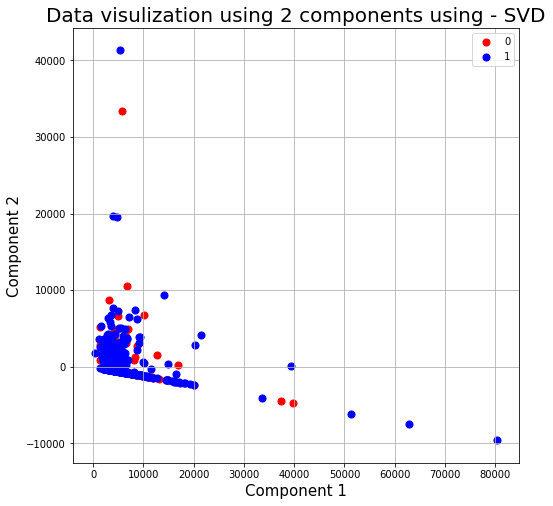

In [48]:
svd = TruncatedSVD(n_components=2)
u = svd.fit_transform(x_train)
s = svd.explained_variance_
vt = svd.components_
dataVisulizationFunction(u, "SVD",y_train)

# 1. RandomForestClassifier

In [49]:
# all parameters not specified are set to their defaults
from sklearn.ensemble import RandomForestClassifier
rft = RandomForestClassifier(n_estimators=1000, n_jobs = -1, random_state=42)

rft.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [50]:
predictions = rft.predict(x_test)

print(len(predictions))
test["Loan_Status"] = pd.DataFrame(predictions, columns =["Loan_Status"])
print(test)
test.Loan_Status[test.Loan_Status == 1 ] = 'Y'
test.Loan_Status[test.Loan_Status == 0 ] = 'N'
print(test)
header = ["Loan_ID", "Loan_Status"]
test.to_csv('submission.csv', columns = header)
# numpy.savetxt('C:/Users/ketan/Desktop/Machine Learning/LogisticRegressionLoanProblem/test.csv',prediction, ,delimiter=',')
# testData

367
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001015    Male     Yes          0      Graduate            No   
1    LP001022    Male     Yes          1      Graduate            No   
2    LP001031    Male     Yes          2      Graduate            No   
3    LP001035    Male     Yes          2      Graduate            No   
4    LP001051    Male      No          0  Not Graduate            No   
5    LP001054    Male     Yes          0  Not Graduate           Yes   
6    LP001055  Female      No          1  Not Graduate            No   
7    LP001056    Male     Yes          2  Not Graduate            No   
8    LP001059    Male     Yes          2      Graduate           NaN   
9    LP001067    Male      No          0  Not Graduate            No   
10   LP001078    Male      No          0  Not Graduate            No   
11   LP001082    Male     Yes          1      Graduate           NaN   
12   LP001083    Male      No         3+      Graduate      

# 2. Neural Network

In [51]:
from sklearn.neural_network import MLPClassifier
nnClassifier = MLPClassifier(solver='adam', learning_rate = 'adaptive',max_iter =500,
                     hidden_layer_sizes=(512,2), random_state=1)

nnClassifier.fit(x_train, y_train)


# Use score method to get accuracy of model
print(("Accuracy of training subset is: {:.3f}").format(nnClassifier.score(x_train, y_train)))

predicted_values = nnClassifier.predict(x_test)

Accuracy of training subset is: 0.697
